In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

### Input 解釋
Source Image：要改變色調的圖片

Reference Image：色調的參考圖片

兩張圖片是從cycleGAN summer2winter_yosemite的test裡面拿的，以我的理解source應該是冬天因為山上有雪而reference是夏天。

In [2]:
source = Image.open('datasets/summer2winter_yosemite/testB/2007-06-24 08:14:31.jpg')
reference = Image.open('datasets/summer2winter_yosemite/testA/2010-10-05 13:45:11.jpg')

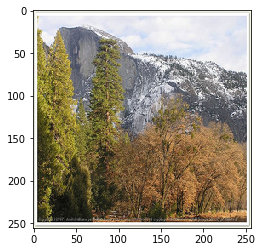

In [3]:
plt.imshow(np.asarray(source))

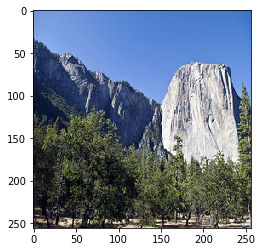

In [4]:
plt.imshow(np.asarray(reference))

### 色彩轉換
我認為直接用RGB的話會影響到亮度，我想要圖片在不影響亮度的情況下改變色調，所以在處理前就從RGB轉到YCbCr。

如果要繼續研究這個naive，我們可以在report裡變比較不同顏色表示法對這個方法的影響。

變數的_c代表converted。

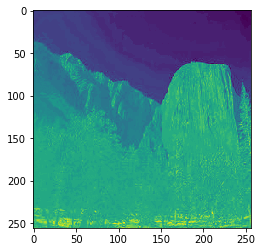

In [16]:
reference_c = np.asarray(reference.convert('YCbCr'))
plt.imshow(reference_c)

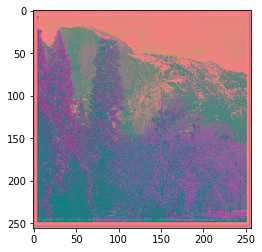

In [24]:
source_c = np.asarray(source.convert('YCbCr'))
plt.imshow(source_c)

### 算色調改變量
讓reference跟source分別對長跟寬平均，接著兩者相減，這樣會得到一個大小為3的array，三個數分別是兩張圖在三個channel平均的差異。

轉成uint8是為了等等可以直接運算。

In [35]:
tone = np.average(np.average(reference_c, axis=0), axis=0) - np.average(np.average(source_c, axis=0), axis=0)
tone = np.uint8(tone)
print(tone)

[225  24 240]


### 調整色調
第一個channel是亮度，我不想讓他有變動。所以就只改變後兩個channel。

在印出來的時候要先轉回RGB。

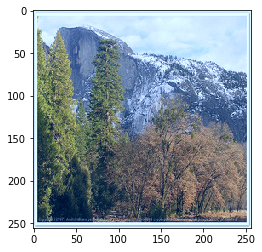

In [44]:
output = np.copy(source_c)
output[:, :, 1] += tone[1]
output[:, :, 2] += tone[2]

outImg = Image.fromarray(output, mode='YCbCr').convert('RGB')
plt.imshow(outImg)

### 比較
再印了一次source image，發現新的圖色調偏藍，合理因為reference的藍天站滿大面積的。

終究是沒有比較夏天的感覺，因為山上看起來還是有雪。

可以怎麼改呢，我還沒想到。

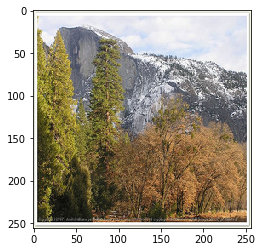

In [45]:
plt.imshow(source)

### 參考PS的做法
[Photoshop Tutorial: How to Quickly Transform Summer into Winter](https://www.youtube.com/watch?v=T1qW0uAt5jw)
* 主要是讓綠色植被上加上白色積雪並且加上飄雪

#### 步驟
1. 把G channel複製出來
2. 對剛剛的拿出來的圖加上失真的Diffuse glow blur，這樣除了積雪，還會看起來有一些飄雪
3. 剛剛blur的東西加上一些透明度，讓原本的顏色可以比較透出來
3. 再把這層用G channel修改的積雪blend上原圖
4. 再來為了加上飄雪再加上一層Gaussian noise
5. 剛剛的飄雪要Gaussian blur一下
6. 然後要quantize剛剛blur完的東西，影片讓140/255以下的灰都變成黑色、142/255以上的灰都拉成白色
7. 再blur一次剛剛的飄雪
8. 最後把飄雪blend到原圖上就好了

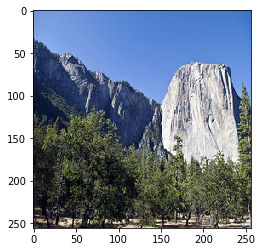

In [46]:
summer = Image.open('datasets/summer2winter_yosemite/testA/2010-10-05 13:45:11.jpg')
plt.imshow(np.asarray(summer))

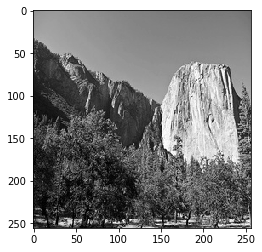

In [101]:
G = np.asarray(summer)[:,:,1]
plt.imshow(G, cmap='gray')

In [63]:
from PIL import ImageFilter

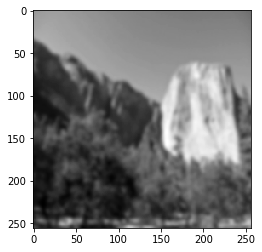

In [103]:
GImg = Image.fromarray(G)
GImg = GImg.filter(ImageFilter.GaussianBlur)
plt.imshow(np.asarray(GImg), cmap='gray')

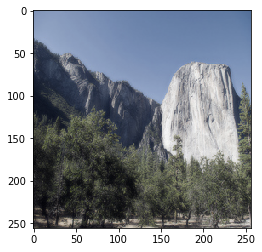

In [155]:
newImg = Image.blend(summer, GImg.convert(mode='RGB'), .5)
plt.imshow(np.asarray(newImg))

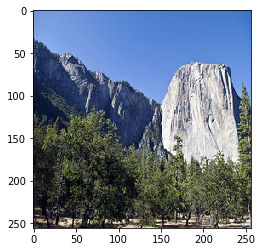

In [89]:
plt.imshow(np.asarray(summer))

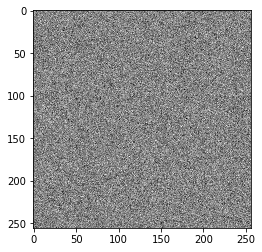

In [150]:
noise = np.random.normal(110, 50, GImg.size)
plt.imshow(noise, cmap='gray')

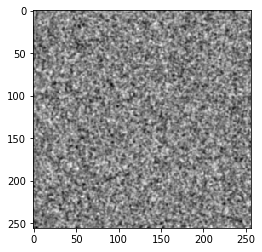

In [151]:
noiseImg = Image.fromarray(noise).convert('RGB')
noiseImg = noiseImg.filter(ImageFilter.GaussianBlur(radius=1)).convert('L')
plt.imshow(np.asarray(noiseImg), cmap='gray')

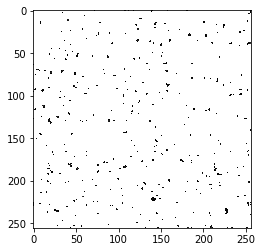

In [152]:
noise = np.asarray(noiseImg)
noise = np.where(noise<140, 255, noise)
plt.imshow(noise, cmap='gray')

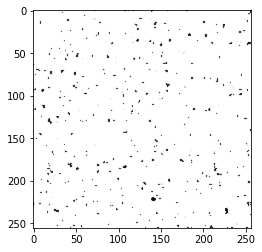

In [153]:
noiseImg = Image.fromarray(noise).convert('RGB').filter(ImageFilter.GaussianBlur(radius=.5)).convert('L')
plt.imshow(np.asarray(noiseImg), cmap='gray')

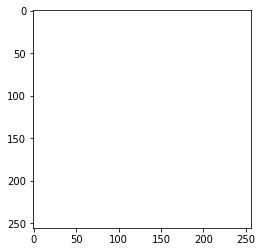

In [146]:
white = Image.new('RGB', newImg.size, 'white')
plt.imshow(np.asarray(white))

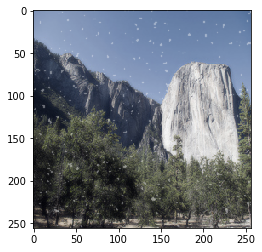

In [156]:
newImg = Image.composite(newImg, white, noiseImg)
plt.imshow(newImg)

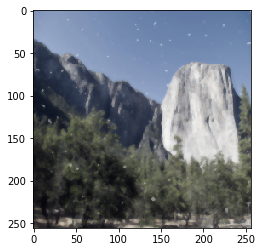

In [173]:
toSummer = newImg.filter(ImageFilter.MedianFilter)
plt.imshow(toSummer)

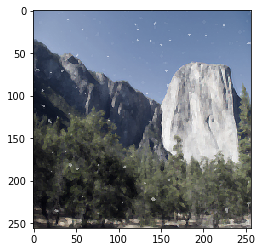

In [174]:
toSummer = toSummer.filter(ImageFilter.SHARPEN)
plt.imshow(toSummer)

In [176]:
from PIL import ImageEnhance

In [178]:
brightEnhance = ImageEnhance.Brightness(toSummer)
colorEnhance = ImageEnhance.Color(toSummer)
contrastEnhance = ImageEnhance.Contrast(toSummer)
sharpEnhance = ImageEnhance.Sharpness(toSummer)

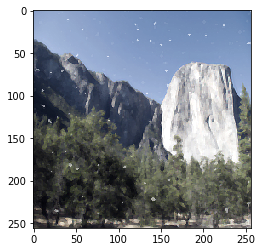

In [180]:
plt.imshow(brightEnhance.enhance(1.1))

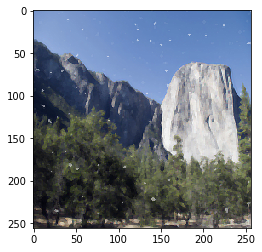

In [181]:
plt.imshow(colorEnhance.enhance(1.5))

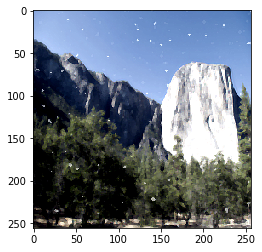

In [182]:
plt.imshow(contrastEnhance.enhance(1.5))

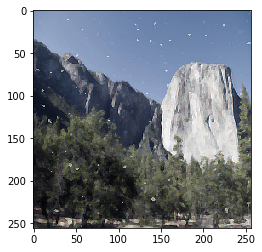

In [183]:
plt.imshow(sharpEnhance.enhance(1.5))

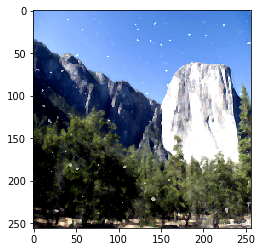

In [185]:
toSummer = colorEnhance.enhance(1.5)
contrastEnhance = ImageEnhance.Contrast(toSummer)
toSummer = contrastEnhance.enhance(1.5)
plt.imshow(toSummer)

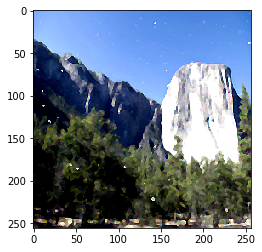

In [188]:
plt.imshow(toSummer.filter(ImageFilter.MedianFilter).filter(ImageFilter.SHARPEN))